# Variational autoencoder (VAE) example - Predictive Multiscale Materials Design Short Course
June 10-14, 2019

Variational autoencoder (VAE) example - Lecture 2

Encoder ---> latent space --> Decoder 

In [1]:
#import packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist

In [2]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [3]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
# mean vector
z_mean = Dense(latent_dim)(h)
# standard deviation vector
z_log_var = Dense(latent_dim)(h)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
def sampling(args):
    z_mean, z_log_var = args
    #Normal dist
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [5]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
#x_decoded_mean is the output for decoder
x_decoded_mean = decoder_mean(h_decoded)

In [6]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)#Square Loss
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)#KL-Divergence Loss
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [7]:
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)

In [8]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#normalization
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
#flaten figures
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [9]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
60000/60000 [==============================] - 6s 100us/sample - loss: 189.9355 - val_loss: 172.3399
Epoch 2/50
60000/60000 [==============================] - 6s 97us/sample - loss: 170.1685 - val_loss: 168.0560
Epoch 3/50
60000/60000 [==============================] - 5s 91us/sample - loss: 166.5711 - val_loss: 165.7400
Epoch 4/50
60000/60000 [==============================] - 5s 89us/sample - loss: 164.4068 - val_loss: 163.7714
Epoch 5/50
60000/60000 [==============================] - 6s 101us/sample - loss: 162.9195 - val_loss: 162.3647
Epoch 6/50
60000/60000 [==============================] - 7s 115us/sample - loss: 161.7221 - val_loss: 161.5313
Epoch 7/50
60000/60000 [==============================] - 6s 96us/sample - loss: 160.6072 - val_loss: 160.2100
Epoch 8/50
60000/60000 [==============================] - 6s 95us/sample - loss: 159.5235 - val_loss: 159.5331
Epoch 9/50


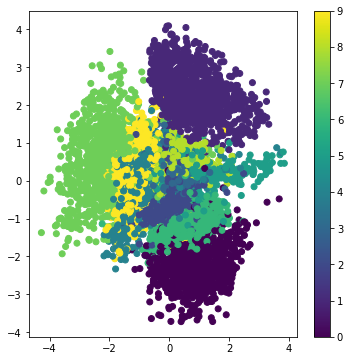

In [10]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [11]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [12]:
# display a 2D manifold of the digits
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

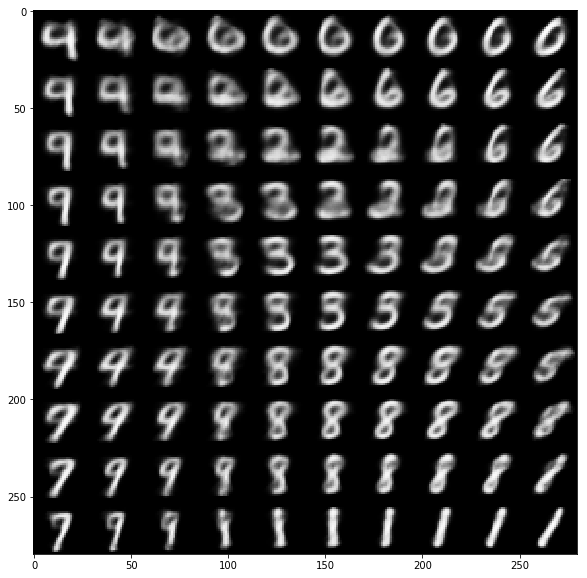

In [13]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])#add by weihao: 1*2
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)#add by weihao: the generated image
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()